In [63]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import random

In [64]:
class PassiveTDAgent:
    """Temporal Difference learning agent for policy evaluation.
    
    Learns value estimates U(s) for each state under a fixed policy pi.
    Uses TD(0) update: U(s) = U(s) + alpha * (R + gamma * U(s') - U(s))
    """
    def __init__(self, pi, all_states=None, alpha=None, gamma=0.9):
        self.pi = pi  # policy function: state -> action
        self.U = {}   # value estimates for each state
        self.Ns = {}  # visit counts for learning rate
        self.gamma = gamma
        
        # Initialize U and Ns for all possible states
        if all_states:
            for s in all_states:
                self.U[s] = 0.0
                self.Ns[s] = 0
        
        if alpha:
            self.alpha = alpha
        else:
            self.alpha = lambda n: 1 / (1 + n)  # learning rate decreases with visits

    def getAction(self, state):
        """Get action from policy."""
        return self.pi(state)
    
    def update(self, state, reward, next_state, terminated):
        """TD update rule: U(s) += alpha * (R + gamma * U(s') - U(s))"""
        # Initialize state if not seen before
        if state not in self.U:
            self.U[state] = 0.0
            self.Ns[state] = 0
        if next_state not in self.U:
            if next_state[0] < 22:
                self.U[next_state] = 0.0
                self.Ns[next_state] = 0
        
        # TD(0) update
        self.Ns[state] += 1
        alpha = self.alpha(self.Ns[state])
        
        # If terminated, next state has value 0
        next_value = 0.0 if terminated else self.U[next_state]
        td_error = reward + self.gamma * next_value - self.U[state]
        self.U[state] += alpha * td_error

    def getEstimatedReward(self, state):
        return self.U[state]
    
    def getAllStates(self):
        return self.U.keys()


In [65]:
env = gym.make('Blackjack-v1', sab=False, natural=False, render_mode=None)
nEpisodes = 10000

In [66]:
# Simple policy: hit (action=1) if player sum < 17, else stick (action=0)
policy = lambda state: 1 if state[0] < 17 else 0

# All possible Blackjack states (player_sum, dealer_showing, usable_ace)
# Player sum: 4-21, Dealer: 1-11, Usable ace: True/False
all_states = [
    (player_sum, dealer_card, usable_ace)
    for player_sum in range(4, 22)
    for dealer_card in range(1, 11)
    for usable_ace in [True, False]
]

# Create agent without MDP wrapper
agent = PassiveTDAgent(
    pi=policy,
    all_states=all_states,
    alpha=None,  # Use default: 1/(1+n)
    gamma=0.9
)

In [67]:
episodeRewards = []
episodeLengths = []

for episode in tqdm(range(nEpisodes)):
    state, info = env.reset()
    terminated = False
    episodeReward = 0
    episodeLength = 0

    while not terminated:
        action = agent.getAction(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        
        # TD update: agent learns value of current state
        agent.update(state, reward, next_state, terminated)
        
        state = next_state
        episodeReward += reward
        episodeLength += 1

    episodeRewards.append(episodeReward)
    episodeLengths.append(episodeLength)

100%|██████████| 10000/10000 [00:00<00:00, 22962.04it/s]


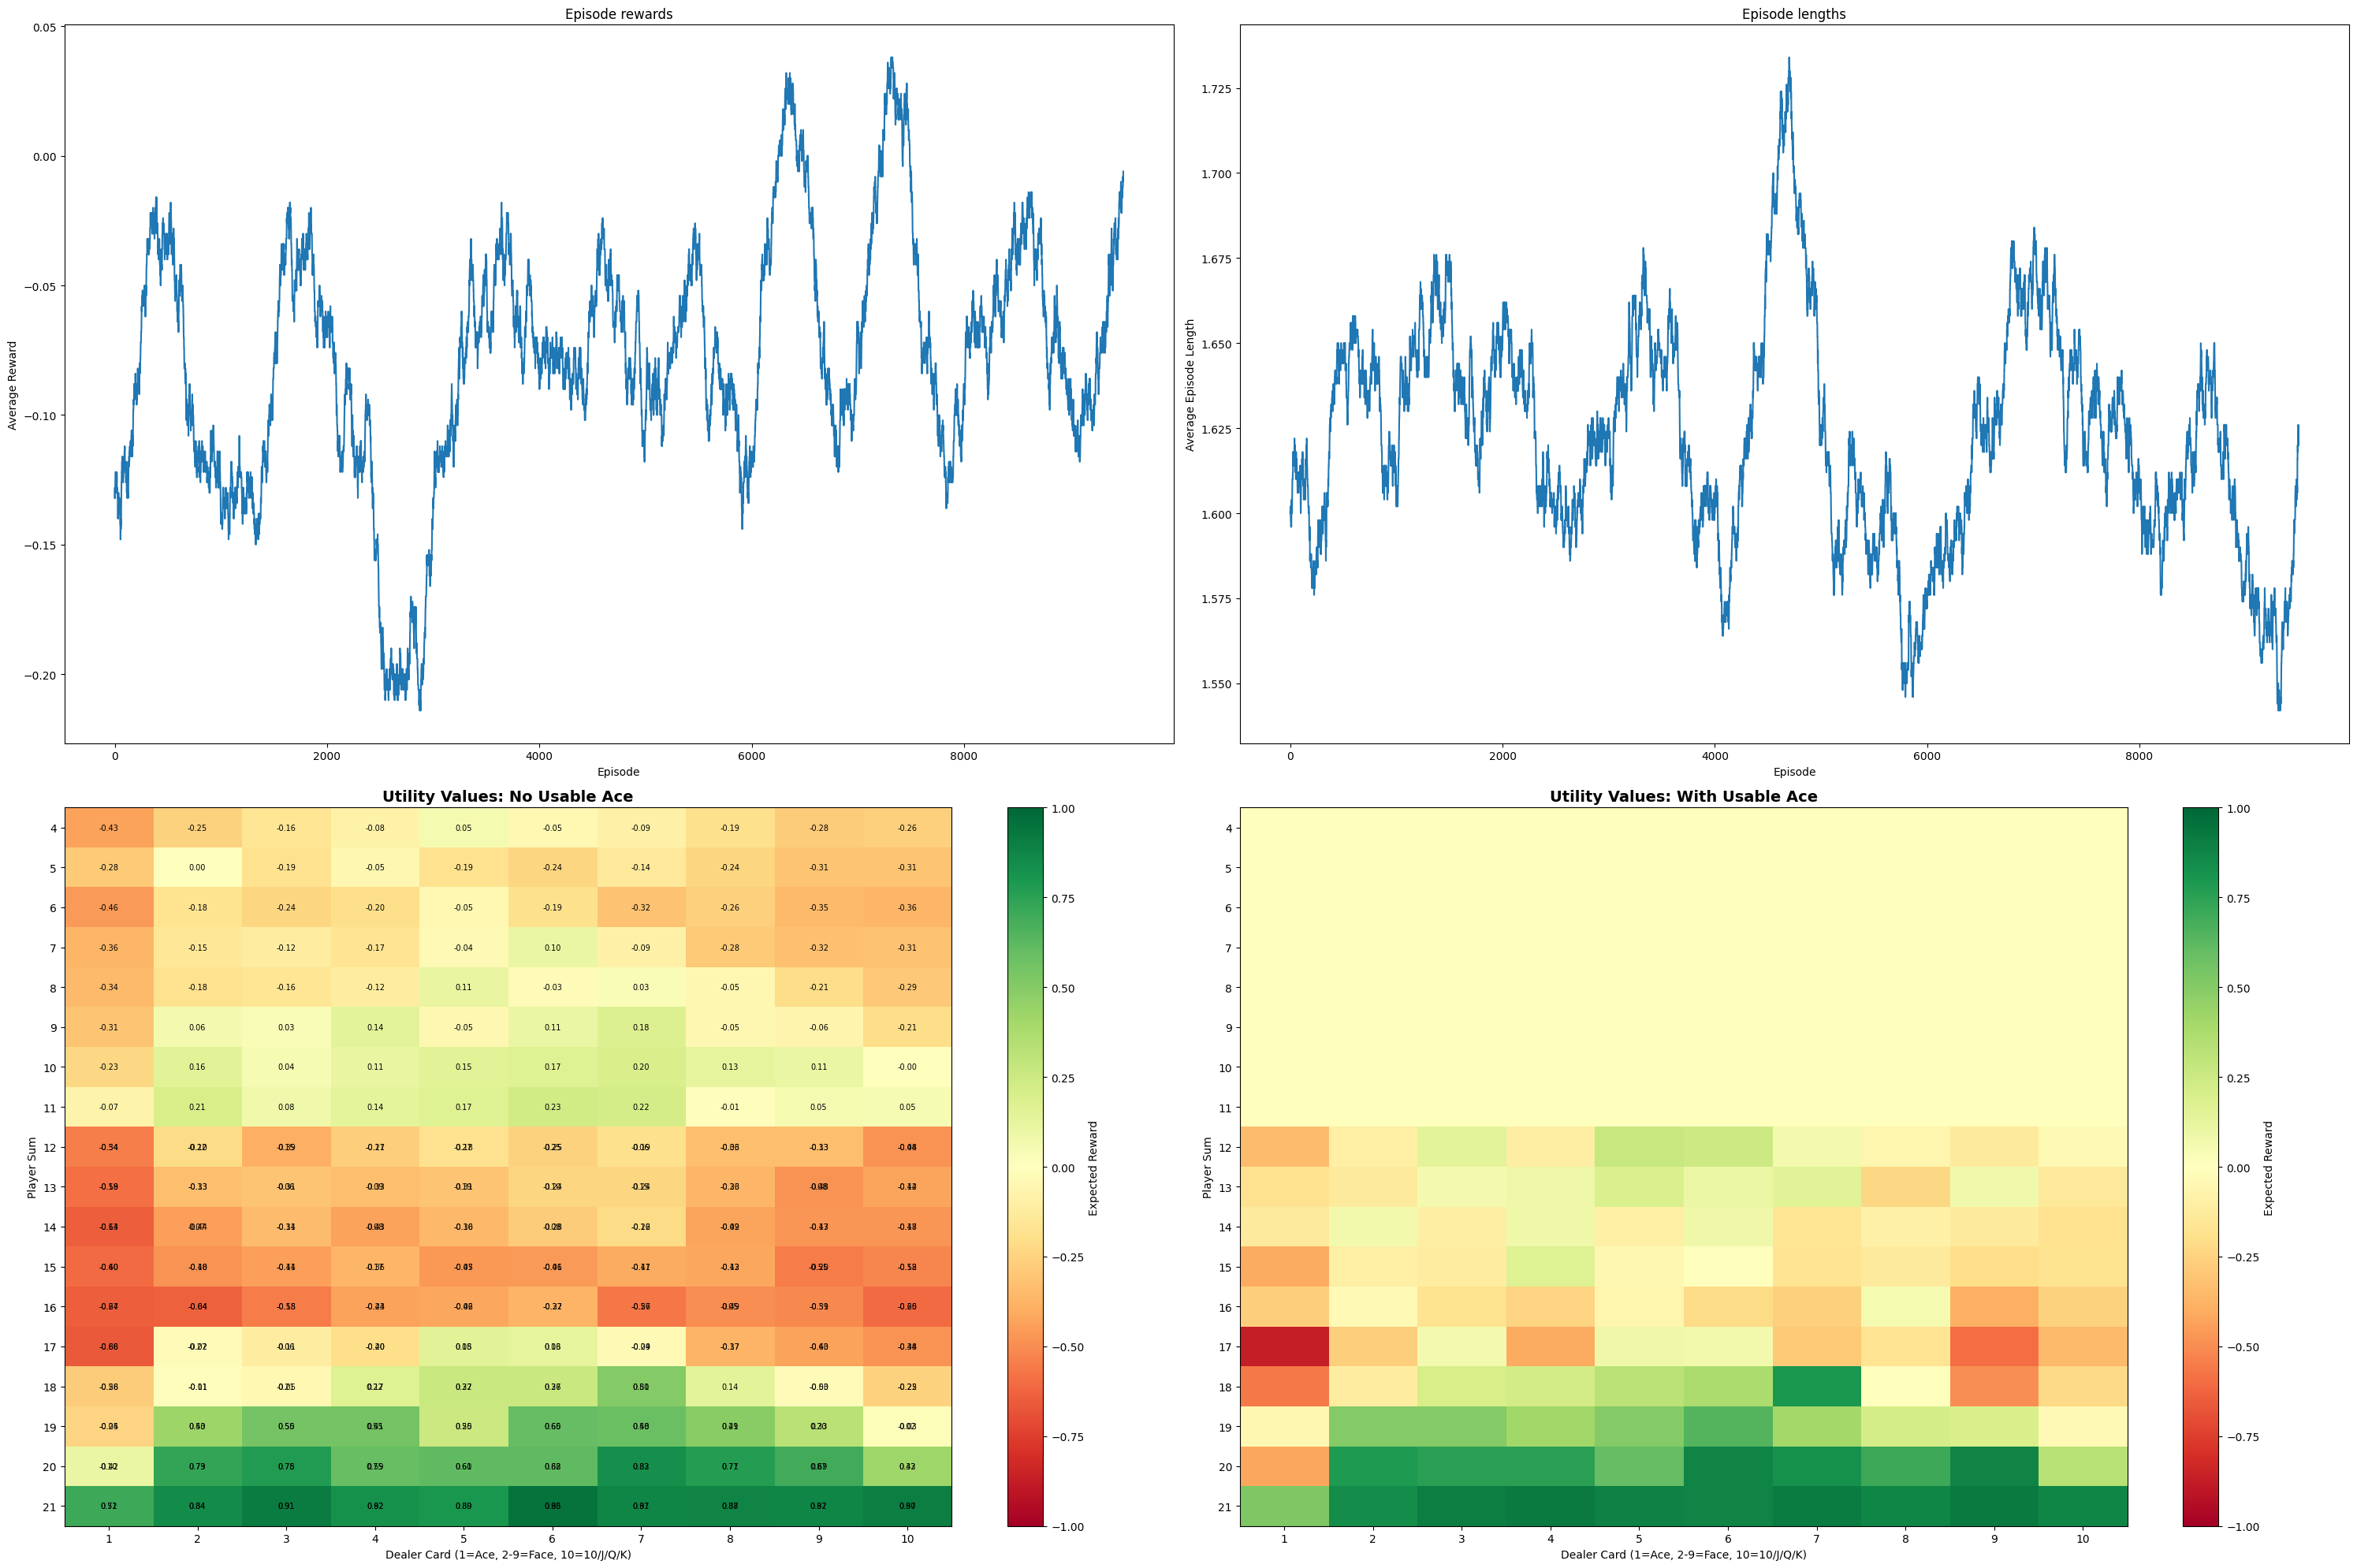

In [ ]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(30, 20))

# Episode rewards (win/loss performance)
axs[0][0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    episodeRewards,
    rolling_length,
    "valid"
    )
axs[0][0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0][0].set_ylabel("Average Reward")
axs[0][0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[0][1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    episodeLengths,
    rolling_length,
    "valid"
    )
axs[0][1].plot(range(len(length_moving_average)), length_moving_average)
axs[0][1].set_ylabel("Average Episode Length")
axs[0][1].set_xlabel("Episode")

# Create heatmaps for utility values
import matplotlib.pyplot as plt
import numpy as np

# Separate data by usable_ace
data_no_ace = np.zeros((18, 10))      # player_sum: 4-21 (rows), dealer_card: 1-10 (cols)
data_with_ace = np.zeros((18, 10))
count_no_ace = np.zeros((18, 10))
count_with_ace = np.zeros((18, 10))

for state in agent.getAllStates():
    player_sum, dealer_card, usable_ace = state
    
    # Skip invalid states (sums > 21)
    if player_sum < 4 or player_sum > 21:
        continue
    
    row = player_sum - 4
    col = dealer_card - 1
    value = agent.getEstimatedReward(state)
    
    if usable_ace in [True, 1]:
        data_with_ace[row, col] = value
        count_with_ace[row, col] += 1
    else:
        data_no_ace[row, col] = value
        count_no_ace[row, col] += 1

# Create side-by-side heatmaps

# Heatmap 1: No usable ace
im1 = axs[1][0].imshow(data_no_ace, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
axs[1][0].set_title('Utility Values: No Usable Ace', fontsize=14, fontweight='bold')
axs[1][0].set_xlabel('Dealer Card (1=Ace, 2-9=Face, 10=10/J/Q/K)')
axs[1][0].set_ylabel('Player Sum')
axs[1][0].set_xticks(range(10))
axs[1][0].set_xticklabels(range(1, 11))
axs[1][0].set_yticks(range(18))
axs[1][0].set_yticklabels(range(4, 22))
plt.colorbar(im1, ax=axs[1][0], label='Expected Reward')

# Add text annotations for heatmap 1
for i in range(18):
    for j in range(10):
        if data_no_ace[i, j] != 0:
            text = axs[1][0].text(j, i, f'{data_no_ace[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=7)

# Heatmap 2: With usable ace
im2 = axs[1][1].imshow(data_with_ace, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
axs[1][1].set_title('Utility Values: With Usable Ace', fontsize=14, fontweight='bold')
axs[1][1].set_xlabel('Dealer Card (1=Ace, 2-9=Face, 10=10/J/Q/K)')
axs[1][1].set_ylabel('Player Sum')
axs[1][1].set_xticks(range(10))
axs[1][1].set_xticklabels(range(1, 11))
axs[1][1].set_yticks(range(18))
axs[1][1].set_yticklabels(range(4, 22))
plt.colorbar(im2, ax=axs[1][1], label='Expected Reward')

# Add text annotations for heatmap 2
for i in range(18):
    for j in range(10):
        if data_with_ace[i, j] != 0:
            text = axs[1][1].text(j, i, f'{data_with_ace[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=7)

plt.tight_layout()
plt.show()

In [69]:
print("Utility Values\nCurrent Hand Value | Dealer Card | Useable Ace in Hand : Estimated Reward")
for state in agent.getAllStates():
    print(f"{state}: {agent.getEstimatedReward(state)}")

Utility Values
Current Hand Value | Dealer Card | Useable Ace in Hand : Estimated Reward
(4, 1, True): 0.0
(4, 1, False): -0.4316233309132031
(4, 2, True): 0.0
(4, 2, False): -0.25380784587977867
(4, 3, True): 0.0
(4, 3, False): -0.1614022856680588
(4, 4, True): 0.0
(4, 4, False): -0.08415803120668336
(4, 5, True): 0.0
(4, 5, False): 0.04982835977935629
(4, 6, True): 0.0
(4, 6, False): -0.04571372192304149
(4, 7, True): 0.0
(4, 7, False): -0.08608546397943723
(4, 8, True): 0.0
(4, 8, False): -0.1880348035530391
(4, 9, True): 0.0
(4, 9, False): -0.28004442424017434
(4, 10, True): 0.0
(4, 10, False): -0.26389420470831515
(5, 1, True): 0.0
(5, 1, False): -0.28203689252472885
(5, 2, True): 0.0
(5, 2, False): 0.0016008644968809813
(5, 3, True): 0.0
(5, 3, False): -0.18718167330937538
(5, 4, True): 0.0
(5, 4, False): -0.04953641624377765
(5, 5, True): 0.0
(5, 5, False): -0.18542803121488027
(5, 6, True): 0.0
(5, 6, False): -0.23599225999256118
(5, 7, True): 0.0
(5, 7, False): -0.135598510767

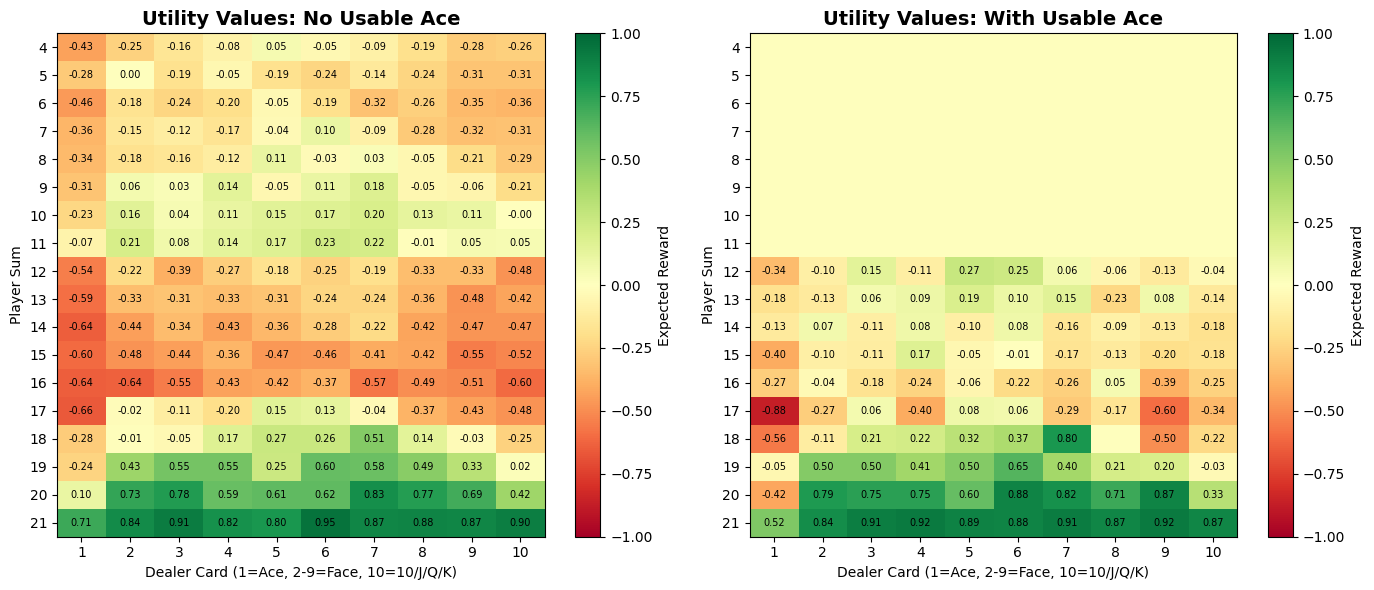


=== Utility Value Heatmap Summary ===
No usable ace - States with learned values: 180
With usable ace - States with learned values: 180

Color scale: Green = Winning (positive value), Red = Losing (negative value)
